In [1]:
# include
import rospy
import numpy as np
import sensor_msgs.point_cloud2 as pc2
from sensor_msgs.msg import PointCloud2, PointField
from std_msgs.msg import Header
import tf.transformations as tf
import math
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
from numpy.polynomial.polynomial import Polynomial
import scipy.optimize as opt
import pandas as pd

generate hexagon poligon

In [2]:
def generate_random_points_on_hexagon_prism(N):
    points = []

    # 윗면 & 아랫면
    while len(points) < N:
        x = np.random.rand()
        y = np.random.rand()
        z2 = 1

        if z2 > 0:
            z = 1
            z_values = [z, -z]

            # store valid (x, y, z) combinations
            for z_val in z_values:
                if len(points) < N:
                    points.append([x-y*0.5, y*math.sqrt(3)/2, z_val])
                else:
                    break
                if len(points) < N:
                    points.append([x-y*0.5, -y*math.sqrt(3)/2, z_val])
                else:
                    break
                if len(points) < N:
                    points.append([-x*0.5-y*0.5, x*math.sqrt(3)/2-y*math.sqrt(3)/2, z_val])
                else:
                    break

        # 앞뒤면

        x = np.random.rand() - 0.5
        z = 2 * np.random.rand() - 1

        y2 = 3/4

        if y2 >= 0:
            # calculate real x values
            y = math.sqrt(y2)
            y_values = [y, -y]

            # store valid (x, y, z) combinations
            for y_val in y_values:
                if len(points) < N:
                    points.append([x, y_val, z])
                else:
                    break
        
        #옆면
        x = np.random.rand() - 0.5
        z = 2 * np.random.rand() - 1

        y2 = 3/4

        if y2 >= 0:
            # calculate real x values
            y = math.sqrt(y2)
            y_values = [y, -y]

            # store valid (x, y, z) combinations
            for y_val in y_values:
                if len(points) < N:
                    points.append([x*0.5 - y_val*math.sqrt(3)/2, x*math.sqrt(3)/2+y_val*0.5,z])
                else:
                    break
        
        x = np.random.rand() - 0.5
        z = 2 * np.random.rand() - 1

        y2 = 3/4

        if y2 >= 0:
            # calculate real x values
            y = math.sqrt(y2)
            y_values = [y, -y]

            # store valid (x, y, z) combinations
            for y_val in y_values:
                if len(points) < N:
                    points.append([x*0.5 + y_val*math.sqrt(3)/2, -x*math.sqrt(3)/2+y_val*0.5,z])
                else:
                    break
    
    return np.array(points[:N])


generate cube

In [3]:
def generate_random_points_on_cube(N):
    points = []  # 빈 리스트로 초기화
    while len(points) < N:
        x = 2 * np.random.rand() - 1
        y = 2 * np.random.rand() - 1
        z = 1
        z_values = [z, -z]
        
        # 유효한 (x, y, z) 조합을 저장
        for z_val in z_values:
            if len(points) < N:
                points.append([x, y, z_val])  # 새로운 점 추가
            else:
                break
        
        y = 2 * np.random.rand() - 1
        z = 2 * np.random.rand() - 1
        
        x1 = 1
        
        if x >= 0:
            # 실제 x 값을 계산
            x = x1
            x_values = [x, -x]
            
            # 유효한 (x, y, z) 조합을 저장
            for x_val in x_values:
                if len(points) < N:
                    points.append([x_val, y, z])  # 새로운 점 추가
                else:
                    break
        
        z = 2 * np.random.rand() - 1
        x = 2 * np.random.rand() - 1
        
        y1 = 1
        
        if y1 >= 0:
            # 실제 y 값을 계산
            y = y1
            y_values = [y, -y]
            
            # 유효한 (x, y, z) 조합을 저장
            for y_val in y_values:
                if len(points) < N:
                    points.append([x, y_val, z])  # 새로운 점 추가
                else:
                    break
    
    return np.array(points[:N])  # 결과를 numpy 배열로 반환


generate cylinder

In [4]:
def generate_random_points_on_cylinder(N):
    points = []
    while len(points) < N:
        x = 2 * np.random.rand() - 1
        y = 2 * np.random.rand() - 1

        z2 = 1 - x**2 - y**2

        if z2 >= 0:
            # calculate real z values
            z = 1
            z_values = [z, -z]

            # store valid (x, y, z) combinations
            for z_val in z_values:
                if len(points) < N:
                    points.append([x, y, z_val])
                else:
                    break

        y = 2 * np.random.rand() - 1
        z = 2 * np.random.rand() - 1

        x2 = 1 - y**2

        if x2 >= 0:
            # calculate real x values
            x = math.sqrt(x2)
            x_values = [x, -x]

            # store valid (x, y, z) combinations
            for x_val in x_values:
                if len(points) < N:
                    points.append([x_val, y, z])
                else:
                    break
        
        z = 2 * np.random.rand() - 1
        x = 2 * np.random.rand() - 1

        y2 = 1 - x**2

        if y2 >= 0:
            # calculate real z values
            y = math.sqrt(y2)
            y_values = [y, -y]

            # store valid (x, y, z) combinations
            for y_val in y_values:
                if len(points) < N:
                    points.append([x, y_val, z])
                else:
                    break

    return np.array(points[:N])


create pointcloud and publish it to ros

In [5]:
def create_pointcloud2(points, frame_id="map"):
    header = Header()
    header.stamp = rospy.Time.now()
    header.frame_id = frame_id

    fields = [
        PointField('x', 0, PointField.FLOAT32, 1),
        PointField('y', 4, PointField.FLOAT32, 1),
        PointField('z', 8, PointField.FLOAT32, 1)
    ]
    
    return pc2.create_cloud(header, fields, points)

def pointcloud_publisher(generated_points):
    rospy.init_node('pointcloud_publisher', anonymous=True)
    pub = rospy.Publisher('/pointcloud', PointCloud2, queue_size=10)
    rate = rospy.Rate(1)
    
    while not rospy.is_shutdown():
        # points = generate_random_points_on_cylinder(3000)
        points = generated_points
        pc_msg = create_pointcloud2(points)
        pub.publish(pc_msg)
        rospy.loginfo("Published PointCloud2 data")
        rate.sleep()


In [6]:
def nonhomogene_terms(n):
    x, y, z = sp.symbols('x y z')
    terms = []
    for order in range(n, -1, -1):
        for max_power in range(order, -1, -1):
            for j in range(order-max_power, -1, -1):
                k = order - max_power - j
                terms.append(x**max_power * y**j * z**k)
                terms.append(y**max_power * z**j * x**k)
                terms.append(z**max_power * x**j * y**k)
    unique_terms = list(dict.fromkeys(terms))
    return unique_terms

def homogene_terms(order):
    x, y, z = sp.symbols('x y z')
    terms = []
    for max_power in range(order, -1, -1):
        for j in range(order-max_power, -1, -1):
            k = order - max_power - j
            terms.append((x**max_power) * (y**j) * (z**k))
            terms.append(y**max_power * z**j * x**k)
            terms.append(z**max_power * x**j * y**k)
    unique_terms = list(dict.fromkeys(terms))
    return unique_terms

In [16]:
from numpy.linalg import inv

def calculate_fourth_order(input_matrix, symbterm):
    # # 입력 행렬에서 각 행을 추출하여 각각의 변수 x, y, z로 지정
    # x1 = input_matrix[:, 0]
    # y1 = input_matrix[:, 1]
    # z1 = input_matrix[:, 2]
    
    # # 심볼릭 변수 x, y, z 생성
    # x, y, z = sp.symbols('x y z')
    # num_rows = input_matrix.shape[0]
    # num_terms = len(symbterm)
    
    # # 출력 행렬 초기화 (n행 m열)
    # output = np.zeros((num_rows, num_terms))
    
    # # symbterm을 함수로 변환
    # term_functions = [sp.lambdify((x, y, z), term, "numpy") for term in symbterm]
    
    # # 함수 행렬을 이용하여 모든 행의 값을 한 번에 계산
    # for i, term_func in enumerate(term_functions):
    #     output[:, i] = term_func(x1, y1, z1)

    # return output
    
    x, y, z = sp.symbols('x y z')
    term_functions = [sp.lambdify((x, y, z), term, "numpy") for term in symbterm]
    output = np.zeros((input_matrix.shape[0], len(symbterm)))
    for i, func in enumerate(term_functions):
        output[:, i] = func(input_matrix[:, 0], input_matrix[:, 1], input_matrix[:, 2])
    return output

def regression_fourth_order(inputMatrix, symbterm):
    # Temp = calculate_fourth_order(inputMatrix, symbterm)
    # Y_target = np.ones((inputMatrix.shape[0], 1))
    # beta = inv(Temp.T @ Temp) @ Temp.T @ Y_target
    # error = Y_target - Temp @ beta

    # return beta.flatten(), error
    A = calculate_fourth_order(inputMatrix, symbterm)
    ones_vec = np.ones((inputMatrix.shape[0], 1))
    beta = np.linalg.lstsq(A, ones_vec, rcond=None)[0].flatten()
    error = ones_vec - A @ beta
    return beta, error

In [8]:
def generate_random_points_on_surface(N):
    points = []
    while len(points) < N:
        x = 2 * np.random.rand() - 1
        y = 2 * np.random.rand() - 1

        z4 = 1 - x**4 - y**4

        if z4 >= 0:
            z = z4**(1/4)
            z_values = [z, -z]

            for z_val in z_values:
                if len(points) < N:
                    points.append([x, y, z_val])
                else:
                    break

        y = 2 * np.random.rand() - 1
        z = 2 * np.random.rand() - 1

        x4 = 1 - y**4 - z**4

        if x4 >= 0:
            x = x4**(1/4)
            x_values = [x, -x]

            for x_val in x_values:
                if len(points) < N:
                    points.append([x_val, y, z])
                else:
                    break

        z = 2 * np.random.rand() - 1
        x = 2 * np.random.rand() - 1

        y4 = 1 - z**4 - x**4

        if y4 >= 0:
            y = y4**(1/4)
            y_values = [y, -y]

            for y_val in y_values:
                if len(points) < N:
                    points.append([x, y_val, z])
                else:
                    break 
    
    return np.array(points[:N])

In [11]:
PP01 = generate_random_points_on_hexagon_prism(3000) + np.random.rand(3000, 3) * 0.0007
PP02 = generate_random_points_on_cube(1000) + np.random.rand(1000, 3) * 0.0005
PP03 = generate_random_points_on_cylinder(70) + np.random.rand(70, 3) * 0.0005
PP04 = generate_random_points_on_cube(200)

shiftReal = [0, 0, -0.01]

PPm_body = PP01.copy()
PPm_body[:,0] = PPm_body[:,0] * 0.576
PPm_body[:,1] = PPm_body[:,1] * 0.576
PPm_body[:,2] = PPm_body[:,2] * 1.165

PPm_panel1 = PP02.copy()
PPm_panel1[:,0] = PPm_panel1[:,0] / 16
PPm_panel1[:,1] = PPm_panel1[:,1] * 1.25
PPm_panel1[:,2] = PPm_panel1[:,2] * 0.576
PPm_panel1 = PPm_panel1 + [0, 2.025, 0]

PPm_panel2 = PP02.copy()
PPm_panel2[:,0] = PPm_panel2[:,0] / 16
PPm_panel2[:,1] = PPm_panel2[:,1] * 1.25
PPm_panel2[:,2] = PPm_panel2[:,2] * 0.576
PPm_panel2 = PPm_panel2 - [0, 2.025, 0]

PPm_box1 = PP04.copy()
PPm_box1[:,0] = PPm_box1[:,0] * 0.333
PPm_box1[:,1] = PPm_box1[:,1] * 0.175
PPm_box1[:,2] = PPm_box1[:,2] * 0.2
PPm_box1 = PPm_box1 + [0, 0.295, -1.365]

PPm_EOC = PP03.copy()
PPm_EOC[:,0] = PPm_EOC[:,0] * 0.09
PPm_EOC[:,1] = PPm_EOC[:,1] * 0.09
PPm_EOC[:,2] = PPm_EOC[:,2] * 0.05
PPm_EOC = PPm_EOC + [-0.115, 0.295, -1.615]

PPm_box2 = PP04.copy()
PPm_box2[:,0] = PPm_box2[:,0] * 0.05
PPm_box2[:,1] = PPm_box2[:,1] * 0.2
PPm_box2[:,2] = PPm_box2[:,2] * 0.1
PPm_box2 = PPm_box2 + [0.2, -0.215, -1.265]

PPm_box3 = PP04.copy()
PPm_box3[:,0] = PPm_box3[:,0] * 0.05
PPm_box3[:,1] = PPm_box3[:,1] * 0.2
PPm_box3[:,2] = PPm_box3[:,2] * 0.2
PPm_box3 = PPm_box3 + [-0.2, -0.215, -1.365]

PPm_total = np.vstack((PPm_body.copy(), PPm_box1.copy(), PPm_EOC.copy(), PPm_box2.copy(), PPm_box3.copy()))
q = [1, 0, 0, 0]
q_scipy = np.roll(q, -1)
rotm = R.from_quat(q_scipy).as_matrix()
PPmR_body = PPm_body.copy() @ rotm.T

In [ ]:
# First plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
h = PPm_total[:,2]
sc = ax.scatter(PPm_total.copy()[:,0], PPm_total.copy()[:,1], PPm_total.copy()[:,2], c=h, cmap='jet', s=1)
plt.colorbar(sc)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_xlim([-2,2])
ax.set_ylim([-4,4])
ax.set_zlim([-2,2])
# ax.view_init(azim=45, elev=30)
plt.title('pointcloud of KOMPSAT-1 model')
plt.show()

In [ ]:
# import numpy as np
# import itertools
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# points = PPm_body.copy()

# # 2. 6차 다항식의 basis terms 만들기
# def generate_polynomial_features(points, degree):
#     n_points = points.shape[0]
#     terms = []
#     powers = []

#     for d in range(degree + 1):
#         for i in range(d + 1):
#             for j in range(d - i + 1):
#                 k = d - i - j
#                 powers.append((i, j, k))
#                 terms.append((points[:, 0] ** i) * (points[:, 1] ** j) * (points[:, 2] ** k))
#                 print((points[:, 0] ** i) * (points[:, 1] ** j) * (points[:, 2] ** k))

#     return np.stack(terms, axis=1), powers

# # 3. 특성 행렬 생성
# degree = 6
# X, powers = generate_polynomial_features(points, degree)

# # 4. 회귀: f(x, y, z) ≈ 1
# # (f(X) ≈ 1 이 되도록 계수 찾기)
# y_target = np.ones(X.shape[0])
# coeffs, residuals, _, _ = np.linalg.lstsq(X, y_target, rcond=None)

# print(f"계수 개수: {len(coeffs)}")
# print(f"잔차 합: {residuals[0] if len(residuals) else '0'}")

# # 5. 곡면 시각화를 위한 그리드 생성
# grid_x, grid_y, grid_z = np.mgrid[-1.2:1.2:50j, -1.2:1.2:50j, -1.2:1.2:50j]
# grid_points = np.stack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()], axis=1)

# X_grid, _ = generate_polynomial_features(grid_points, degree)
# f_vals = X_grid @ coeffs
# f_vals = f_vals.reshape(grid_x.shape)

# # 6. 등고면 (isosurface) 그리기
# from skimage import measure

# verts, faces, _, _ = measure.marching_cubes(f_vals, level=1.0)

# # 좌표 변환 (mgrid는 0~49 인덱스라 정규화 필요)
# scale = np.linspace(-1.2, 1.2, 50)
# verts = verts / 49 * 2.4 - 1.2  # 스케일 조정

# # 7. 시각화
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(PPm_body.copy()[:,0], PPm_body.copy()[:,1], PPm_body.copy()[:,2], c=PPm_body.copy()[:,2], cmap='jet', s=1)
# mesh = Poly3DCollection(verts[faces], alpha=0.6)
# mesh.set_edgecolor('k')
# ax.add_collection3d(mesh)

# ax.set_xlim(-1.2, 1.2)
# ax.set_ylim(-1.2, 1.2)
# ax.set_zlim(-1.2, 1.2)
# ax.set_title("6차 암시적 다항식으로 근사된 폐곡면")
# plt.colorbar(sc)
# plt.tight_layout()
# plt.show()


[1. 1. 1. ... 1. 1. 1.]
[1.1650084  1.16541002 1.16553477 ... 0.57042592 0.52912196 0.52928733]
[ 0.33415272 -0.3339456  -0.27258308 ... -0.19793649  0.48776334
 -0.01110015]
[-0.12163264 -0.12191303 -0.22819901 ...  0.46194099  0.29446864
 -0.56943185]
[1.35724458 1.3581805  1.35847129 ... 0.32538573 0.27997005 0.28014508]
[ 0.38929073 -0.38918355 -0.31770505 ... -0.1129081   0.25808629
 -0.00587517]
[1.11658041e-01 1.11519667e-01 7.43015345e-02 ... 3.91788543e-02
 2.37913078e-01 1.23213302e-04]
[-0.14170305 -0.14207867 -0.26597388 ...  0.26350312  0.15580983
 -0.30139306]
[-0.04064388  0.04071232  0.06220319 ... -0.09143498  0.14363101
  0.00632078]
[0.0147945  0.01486279 0.05207479 ... 0.21338948 0.08671178 0.32425263]
[1.58120134 1.58283716 1.58334552 ... 0.18560845 0.1481383  0.14827724]
[ 0.45352697 -0.45355841 -0.37029629 ... -0.06440571  0.13655913
 -0.00310965]
[1.30082556e-01 1.29966137e-01 8.66010217e-02 ... 2.23486339e-02
 1.25885034e-01 6.52152400e-05]
[ 3.73108382e-02 -3.

RuntimeError: No surface found at the given iso value.

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from skimage.measure import marching_cubes
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# def generate_homogeneous_features(XYZ, degree=6):
#     poly = PolynomialFeatures(degree=degree, include_bias=False)
#     features = poly.fit_transform(XYZ)

#     homogeneous_mask = np.sum(poly.powers_, axis=1) == degree
#     homogeneous_features = features[:, homogeneous_mask]

#     return homogeneous_features, poly.powers_[homogeneous_mask]

# def fit_homogeneous_polynomial(XYZ, degree=6):
#     X_poly, powers = generate_homogeneous_features(XYZ, degree)

#     scaler = StandardScaler()
#     X_poly_scaled = scaler.fit_transform(X_poly)

#     Y_target = np.random.uniform(0.5, 1.5, size=(XYZ.shape[0]))
#     model = LinearRegression(fit_intercept=True)
#     model.fit(X_poly_scaled, Y_target)
#     coefficients = model.coef_

#     F_predicted = model.predict(X_poly_scaled)
#     print("F_predicted mean value: ", np.mean(np.abs(F_predicted)))

#     return coefficients, powers

# pca = PCA(n_components=3)
# PPm_pca = pca.fit_transform(PPm_body.copy())

# coefficients, powers = fit_homogeneous_polynomial(PPm_pca)
# equation_term = []
# for coef, power in zip(coefficients, powers):
#     term = f"{coef:.4f} * X^{power[0]} * Y^{power[1]} * Z^{power[2]}"
#     equation_term.append(term)

# print(" + ".join(equation_term) + " = 0")

# def visualize_homogeneous_surface(coefficients, powers):
#     x, y, z = sp.symbols('x y z')

#     F = sum(coef * x**p[0] * y**p[1] * z**p[2] for coef, p in zip(coefficients, powers))

#     x_vals = np.linspace(-6, 6, 50)
#     y_vals = np.linspace(-6, 6, 50)
#     z_vals = np.linspace(-6, 6, 50)
#     X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')

#     F_func = sp.lambdify((x, y, z), F, "numpy")
#     F_values = F_func(X, Y, Z)
#     print(F_values.shape)

#     verts, faces, _, _ = marching_cubes(F_values, level=0, spacing=(0.1, 0.1, 0.1))
    
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     sc = ax.scatter(PPm_body.copy()[:,0], PPm_body.copy()[:,1], PPm_body.copy()[:,2], c=PPm_body.copy()[:,2], cmap='jet', s=1)
#     mesh = Poly3DCollection(verts[faces], alpha=0.1, facecolor = 'red')
#     ax.add_collection3d(mesh)

#     ax.set_xlim([-6, 6])
#     ax.set_ylim([-6, 6])
#     ax.set_zlim([-6, 6])
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     plt.colorbar(sc)
#     plt.title('Homogeneous surface')
#     plt.show()

# visualize_homogeneous_surface(coefficients, powers)

In [ ]:
x, y, z = sp.symbols('x y z')
order = 6
# PPm_use = generate_random_points_on_surface(1000)
PPm_use = PPm_body.copy()

center_shift = np.mean(PPm_use.copy(), axis=0)
PPm_shift = PPm_use.copy() - center_shift.copy()

shiftReal = np.array(shiftReal)
shiftReal_T = shiftReal.copy().reshape(-1, 1)
shiftResidue = shiftReal_T.copy()
center_shift_T = center_shift.copy().reshape(-1, 1)
shiftResidue = shiftResidue.copy() - center_shift_T.copy()

TermsB = homogene_terms(order)
betaB = sp.symbols(f'beta0:{len(TermsB)}', real=True)
f2 = sum(betaB[i] * TermsB[i] for i in range(len(TermsB)))

beta_values, error = regression_fourth_order(PPm_shift.copy(), TermsB.copy())
error_shift = error.copy()

shiftSet = []
shift1Set = []
shiftResidueSet = []
shiftSum = np.vstack((0,0,0))
numIterations = 10
shiftSum = center_shift_T.copy()

beta_values_sympy = sp.Matrix(beta_values.copy().T)

f2_substitued = f2.subs(dict(zip(betaB, beta_values_sympy.copy())))
f2_translated = f2_substitued.copy().subs({x: x - center_shift[0], y: y - center_shift[1], z: z - center_shift[2]})
f2_translated_expanded = sp.expand(f2_translated.copy())

total_degree_exp = sp.Poly(f2_translated_expanded, (x, y, z)).total_degree()
homogeneoue_terms = [term for term in f2_translated_expanded.as_ordered_terms() if sp.Poly(term, (x, y, z)).total_degree() == total_degree_exp]
f2_translated_expanded = sum(homogeneoue_terms)

(3,)
[ 3.60642857e+01  6.81476374e+01  4.50966588e-01  1.20415822e+00
 -4.70854031e-02 -5.33267961e-03  7.51274055e-02 -2.49233550e-01
 -1.05758218e-02  3.96448601e+02 -2.99287168e+00 -1.19608455e+00
  8.45229470e-01 -1.64197494e+00  1.78156943e-02 -2.70393066e+00
 -8.64220787e+01 -1.21494095e+00  9.12221991e-01  1.00189283e-01
 -6.16990659e-02  8.98899717e-01  1.00138113e-01  1.60826142e-01
 -9.11699457e-01 -2.59778312e+00  3.72540953e-01 -4.38657564e+00]
Matrix([[36.0642857325857], [68.1476374443491], [0.450966588185158], [1.20415821661095], [-0.0470854031261947], [-0.00533267960875128], [0.0751274054796824], [-0.249233550256275], [-0.0105758217673626], [396.448600929757], [-2.99287167651841], [-1.19608454810126], [0.845229470074392], [-1.64197493612576], [0.0178156942915053], [-2.70393066086262], [-86.4220787383967], [-1.21494095111832], [0.912221990757216], [0.100189283147824], [-0.0616990658966725], [0.898899717294935], [0.100138112939407], [0.160826141976741], [-0.911699456679646

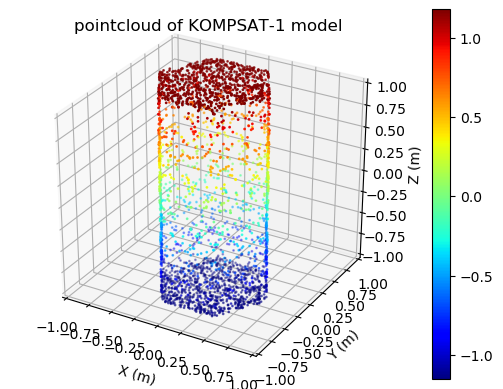

In [14]:
# First plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
h = PPm_shift[:,2]
sc = ax.scatter(PPm_shift.copy()[:,0], PPm_shift.copy()[:,1], PPm_shift.copy()[:,2], c=h, cmap='jet', s=1)
plt.colorbar(sc)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# ax.view_init(azim=45, elev=30)
plt.title('pointcloud of KOMPSAT-1 model')
plt.show()

In [ ]:
print(f2_translated_expanded)

Number of zero crossings: 0


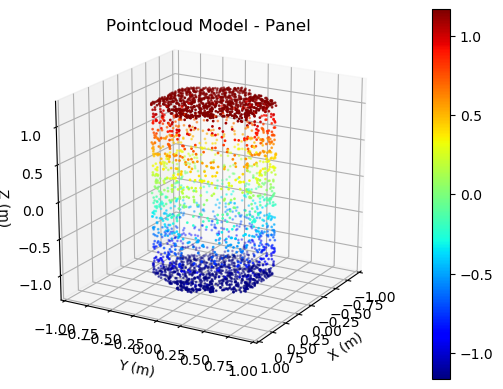

In [15]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(PPm_use[:,0], PPm_use[:,1], PPm_use[:,2], c=PPm_use[:,2], cmap='jet', s=1)

x, y, z = sp.symbols('x y z')

x_vals = np.linspace(-6, 6, 50)
y_vals = np.linspace(-6, 6, 50)
z_vals = np.linspace(-6, 6, 50)
X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals)

f2_using = f2_translated_expanded.copy() - 1

f_lamdified = sp.lambdify((x, y, z), f2_using, "numpy")
F = f_lamdified(X, Y, Z)

zero_mask = np.isclose(F, 0, atol=1e-3)
num_zeros = np.sum(zero_mask)
print(f'Number of zero crossings: {num_zeros}')

verts, faces, _, _ = marching_cubes(F, level=0)
mesh = Poly3DCollection(verts[faces], alpha=0.1, facecolor=(0.99, 0.75, 0.12))
ax.add_collection3d(mesh)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.view_init(elev=20, azim=30)
plt.colorbar(sc)
plt.title('Pointcloud Model - Panel')
plt.show()